<a href="https://colab.research.google.com/github/Baldezo313/Some-real-world-machine-learning-project/blob/main/PROJET_12_MODELISATION_DES_COURS_BOURSIERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJET 12 : MODELISATION DES COURS BOURSIERS  

Avez-vous l'intention d'acheter des actions dans le marché boursier ? Si vous posséder des actions d'une entreprise dont les profits augmentent alors vous gagnerez de l'argent. En
revanche, si cette entreprise a une mauvaise performance et que ses bénéfices chutent alors vous perdrez de l'argent. Investir en bourse est tout un art. Il faut pouvoir acheter les actions de la 'bonne entreprise' au bon moment. Heureusement, il est possible de prédire les futurs prix des actions d'une société sur la base de données historiques. Cela permet aux investisseurs d'avoir une idée sur les entreprises intéressantes et le moment favorable pour acheter des actions.   

Dans ce projet, nous construirons un modèle [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) de prévisions des futurs prix de l’indice du [Dow Jones](https://fr.wikipedia.org/wiki/Dow_Jones_Industrial_Average) en fonction des prix historiques de cet indice.  
Il s'agit ici d'un projet de Modélisation d’une  [série temporelle](https://en.wikipedia.org/wiki/Time_series)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import datetime
import warnings
warnings.filterwarnings("ignore")

**DONNEES**  

Pour réaliser ce projet, nous utiliserons les indices du Dow Jones. Pour collecter les données,
nous utiliserons  [Yahoo Finance](https://finance.yahoo.com/quote/%5EDJI/history/?period1=1196706600&period2=1512325800&interval=1d&filter=history&frequency=1d&guce_referrer=aHR0cHM6Ly9zdWJzY3JpcHRpb24ucGFja3RwdWIuY29tL2Jvb2svYmlnX2RhdGFfYW5kX2J1c2luZXNzX2ludGVsbGlnZW5jZS85NzgxNzg4MzkwMDQwLzIvY2gwMmx2bDFzZWMyMy9jb2xsZWN0aW5nLXRoZS1kYXRhc2V0&guce_referrer_sig=AQAAAJOsCwEGFKsdgIaYSkoBHDORhG5VqZSF_OahJgxWoSekyzlJz_wCbkGewE-3jfUkZZ7QmJG-U4sFrcGsrXj4zsSlX3bCkaQ_bxbG90dVubNhg8_SwRFcN10tdDnti0mnRbkunhnokXTHMCr9-6vsOuR4vIEAvtIzsWSKjpJxcrmJ). Nous avons téléchargé au format csv les prix historiques journaliers allant du 03 décembre 2007 au 03 décembre 2017 soit 10 ans de données sur les
indices du Dow Jones.

In [2]:
# Importation des données
dow_jones = pd.read_csv('https://raw.githubusercontent.com/Baldezo313/Some-real-world-machine-learning-project/refs/heads/main/Machine-Learning-par-la-pratique-avec-Python-master/dow_jones_2007_2017.csv?token=GHSAT0AAAAAAC4VKTEQBDX7KCVSBIIY5ZTCZ4OC6CQ')
dow_jones.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-12-03,13368.219727,13407.240234,13296.280273,13314.570313,13314.570313,212170000
1,2007-12-04,13311.240234,13316.280273,13237.589844,13248.730469,13248.730469,204940000
2,2007-12-05,13244.009766,13460.240234,13244.009766,13444.959961,13444.959961,256800000
3,2007-12-06,13445.849609,13632.900391,13426.179688,13619.889648,13619.889648,197270000
4,2007-12-07,13618.269531,13668.099609,13601.360352,13625.580078,13625.580078,179420000


In [3]:
# Structure de la dataframe dow_jones
dow_jones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2519 non-null   object 
 1   Open       2519 non-null   float64
 2   High       2519 non-null   float64
 3   Low        2519 non-null   float64
 4   Close      2519 non-null   float64
 5   Adj Close  2519 non-null   float64
 6   Volume     2519 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.9+ KB


L'ensemble des données contient 2519 observations et 7 variables :  
* Date : date ;  
* Open : prix de l'indice du Dow Jones à l'ouverture du marché ;  
* High : prix le plus élevé de l'indice atteint dans la journée ;
* Low : prix le plus bas de l'indice atteint dans la journée ;
* Close : prix de l'indice à la clôture de la journée ;
* Adj Close : prix de clôture ajusté. Le prix de clôture ajusté tient compte de divers facteurs et, sur la base de ceux-ci, génère la valeur réelle des actions de la société. Ici, nous regardons la valeur de l'indice DJIA (Dow Jones Industrial Average) donc, la plupart du temps, le prix de clôture et le prix de clôture ajusté sont les mêmes ;
* Volume : nombre d'indices négociés dans la journée.

Le prix de l'indice à l'ouverture d'une journée est proche du prix de clôture au jour précédent. Donc, nous n'allons pas considérer la variable Open. De plus, avec les données dont nous
disposons, nous ne pouvons pas connaître les moments de la journée où le prix le plus élevé et le prix le plus bas ont été atteint. Donc nous ne pourrons pas prédire ces prix. Notre objectif sera alors de prédire les prix ajustés de clôture pour les prochains jours de trading ce qui nous permettra d'avoir une compréhension globale de la tendance.  

L'affichage des premières lignes de la dataframe dow_jones indique que les prix de clôture sont quasiment égaux aux prix ajustés de clôture. Nous partons du principe selon lequel les prix ajustés de clôture prennent en compte plusieurs facteurs important et donnent la valeur réelle de l'action de la société. C'est pour cela que nous choisissons de travailler avec la variable *Adj Close*.

In [4]:
# Dataframe simplifiée
df = dow_jones[['Date', 'Adj Close']]

# Colonne 'Date' au format DateTime
df['Date'] = pd.to_datetime(df['Date'])

# Définir la colonne 'Date' en tant qu'indices
df.set_index('Date', inplace = True)

# Affichage des 5 premières lignes de df
df.head()

,Adj Close
Date,
2007-12-03,13314.570313
2007-12-04,13248.730469
2007-12-05,13444.959961
2007-12-06,13619.889648
2007-12-07,13625.580078


In [5]:
# Affichage des 5 dernières lignes de df
df.tail()

,Adj Close
Date,
2017-11-27,23580.779297
2017-11-28,23836.710938
2017-11-29,23940.679688
2017-11-30,24272.349609
2017-12-01,24231.589844


### ANALYSE DE LA SERIE TEMPORELLE DES PRIX AJUSTES DE CLOTURE DU DOW JONES  


In [6]:
# Résumé statistique
df.describe()

,Adj Close
count,2519.000000
mean,14389.746939
std,3806.313389
min,6547.049805
25%,11411.595215
50%,13471.219727
75%,17525.764649
max,24272.349609


Au cours de la période 2007-2017, le prix de l'indice a évolué entre 6547,05 et 24272,35 dollars.  
La moyenne et la médiane sont relativement proches ce qui indique que la distribution des prix suit probablement une loi normale.

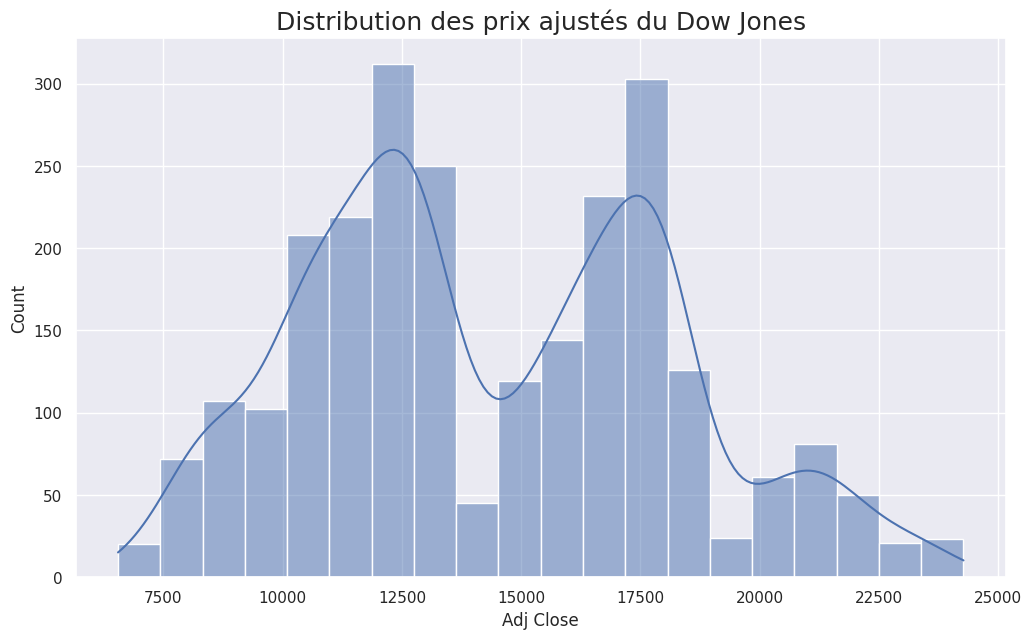

In [7]:
# Distribution des prix
sns.set(rc={'figure.figsize':(12,7)})
sns.histplot(df['Adj Close'], kde=True)
plt.title("Distribution des prix ajustés du Dow Jones", fontsize = 18)
plt.show()

La distribution des prix du Dow Jones est bimodale indiquant qu'il y a deux pics avec une chute au milieu. La courbe de densité est sinusoïdale montrant une alternance de montée et de chute du prix de l'indice ce qui est plutôt commun aux cours des actions qui sont majoritairement des séries non-stationnaires. En effet les gens attendent que les prix des actions chutent pour acheter et espèrent que les prix augmentent dans un avenir plus ou moins proche afin de les vendre et de gagner un bénéfice.

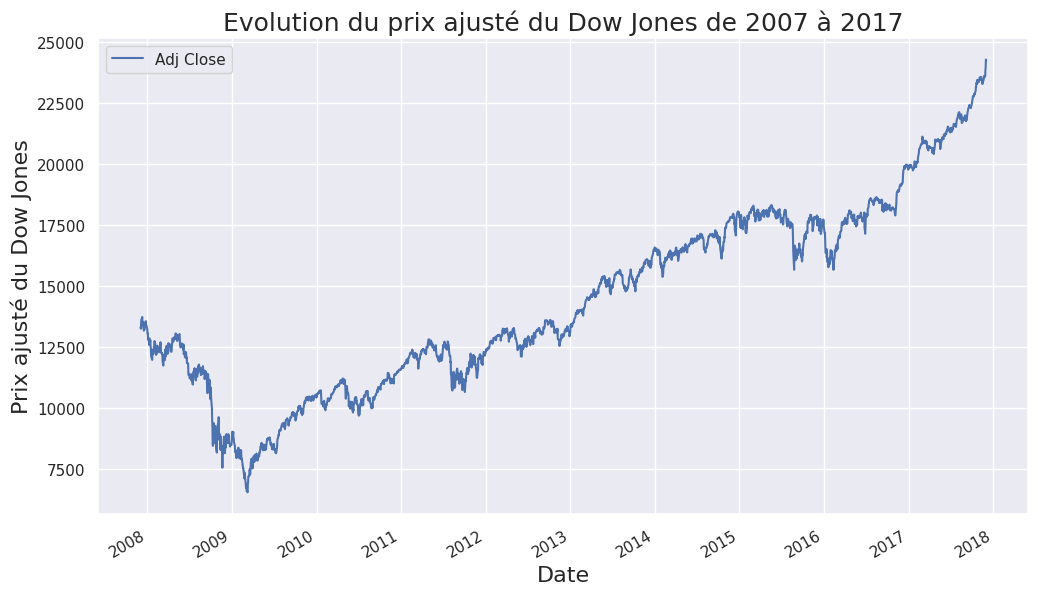

In [8]:
# Visualisation de l'évolution du prix
df.plot()
plt.title("Evolution du prix ajusté du Dow Jones de 2007 à 2017", fontsize = 18)
plt.xlabel ('Date', fontsize = 16)
plt.ylabel('Prix ajusté du Dow Jones', fontsize = 16)
plt.show()

Globalement, l'évolution du prix de l'indice entre 2007 et 2017 a une tendance haussière. Ceci nous indique également que la série n’est pas stationnaire.

### STATIONNARITE  

Est-ce que notre série temporelle est stationnaire ou non ? Avant de répondre à cette question, il faut comprendre pourquoi vérifie-t-on la stationnarité d'une série chronologique. En effet, si une série temporelle est stationnaire alors on peut utiliser les modèles [ARMA](https://en.wikipedia.org/wiki/Autoregressive_moving-average_model) pour prédire ses prochaines valeurs. Si la série n'est pas stationnaire alors il faudra la transformer d'abord en une série stationnaire avant de pouvoir utiliser un modèle ARMA.  

Pour qu'une série temporelle soit stationnaire, il ne doit y avoir aucune tendance, ni aucun changement évident de variance ou de dynamique (la série doit avoir une variance constante et
une dynamique de temps constante).   

L'analyse de l'histogramme et de l'évolution de notre série temporelle nous montre qu'elle présente un changement de dynamique et aussi une tendance haussière. Alors elle n'est pas
stationnaire. Nous devons donc la transformer en une série stationnaire. Mais avant de le faire, nous allons vérifier la non-stationnarité de notre série temporelle par un test statistique :  le test de [Dicky-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test).  
L'hypothèse nulle du test de Dicky-Fuller est que la série temporelle n'est
pas stationnaire en raison de la tendance.


In [9]:
# Test de Dicky-Fuller
results = adfuller(df['Adj Close'])
print(type(results))
print(results)

<class 'tuple'>
(1.2543740484097037, 0.9963408448678397, 20, 2498, {'1%': -3.4329705094097114, '5%': -2.8626977267304357, '10%': -2.5673863028421136}, 31617.41265211667)


Comme vous le voyez, les résultats du test de Dicky-Fuller sont stockés dans un tuple.  
* Le premier élément de ce tuple est la statistique de test. Plus ce nombre est négatif, plus il est probable que la série soit stationnaire.
* Le deuxième élément du tuple est la p-valeur du test. Si la p-valeur est inférieure à 0.05, nous rejetons l'hypothèse nulle et supposons donc que la série temporelle est stationnaire.
* Le dictionnaire qu'il y a dans le tuple stocke les valeurs critiques (seuils) qui correspondent à différentes p-valeur. Par exemple dans notre cas, si nous considérons une p-valeur inférieure ou égale à 0,05 (5%), la statistique de test devra être inférieure à -2,8627 avant de pouvoir rejeter l'hypothèse nulle et donc supposer que la série est stationnaire.  

La statistique de test est égale à 1.25 avec une p-valeur de 0.996. Nous acceptons donc l'hypothèse nulle selon laquelle la série n’est pas temporelle en raison de la tendance.

A partir de la visualisation et du résultat du test de Dicky-Fuller, nous pouvons conclure que notre série temporelle est non-stationnaire. Il est très important de toujours visualiser la série chronologie et de faire aussi le test avant de tirer une conclusion définitive.

Transformons à présent nos données en une série stationnaire. Une façon très courante de rendre une série chronologique stationnaire est de prendre sa différence. C'est-à-dire, de chaque valeur de la série soustraire la valeur précédente.

In [10]:
# Transformation en une série stationnaire
df_stat = df.diff()

# Affichage de df_stat
df_stat.head()

,Adj Close
Date,
2007-12-03,NaN
2007-12-04,-65.839844
2007-12-05,196.229492
2007-12-06,174.929687
2007-12-07,5.690430


In [11]:
df_stat.tail()

,Adj Close
Date,
2017-11-27,22.789063
2017-11-28,255.931641
2017-11-29,103.968750
2017-11-30,331.669921
2017-12-01,-40.759765


C'est tout à fait normal que la première valeur soit NaN (valeur manquante) car il n'y a pas de valeur précédente à soustraire.

* Supprimons la ligne contenant cette valeur manquante :

In [12]:
df_stat = df_stat.dropna()

* Faisons encore le test statistique de Dicky-Fuller pour vérifier la stationnarité de la nouvelle série :

In [13]:
results2 = adfuller(df_stat['Adj Close'])
print(results2)

(-11.029880558890534, 5.703548257818552e-20, 19, 2498, {'1%': -3.4329705094097114, '5%': -2.8626977267304357, '10%': -2.5673863028421136}, 31604.126162811706)


La statistique de test est cette fois-ci égale à -11,03 avec une p-valeur pratiquement nulle (5,70e-20). Nous rejetons donc l'hypothèse nulle. La série est donc stationnaire.

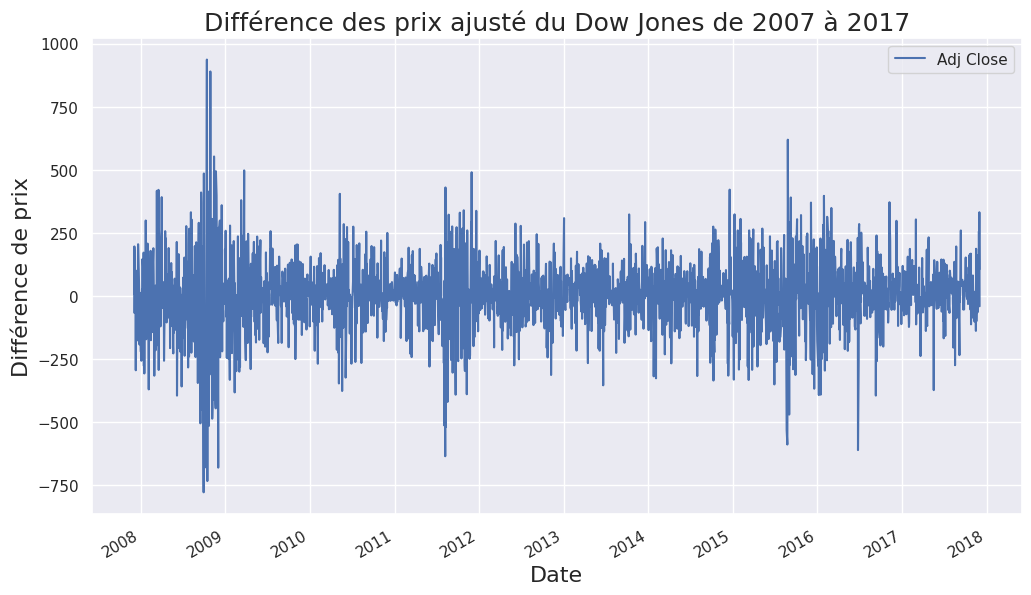

In [14]:
# Visualisation de la nouvelle série staionnaire
df_stat.plot()
plt.title("Différence des prix ajusté du Dow Jones de 2007 à 2017", fontsize = 18)
plt.xlabel ('Date', fontsize = 16)
plt.ylabel('Différence de prix', fontsize = 16)
plt.show()

Nous remarquons qu'il n'y a plus de tendance dans la nouvelle série. La nouvelle série est donc bel et bien stationnaire.  


Parfois, il est nécessaire de prendre la différence plus d'une fois avant de pouvoir rendre une série non-stationnaire en une série stationnaire. Après chaque opération de différenciation, vous devez revisualiser la série et refaire le test statistique. Cela vous permet de connaître l'ordre de différenciation *d* nécessaire pour transformer votre série non stationnaire en une série stationnaire. Par exemple, si vous avez dû faire deux fois la différenciation avant que la série ne devienne stationnaire, alors l'ordre de différenciation est égal à 2. Il ne faut pas non plus différencier plus qu'il n'en faut. Connaître l'ordre de différenciation est très important pour la phase de modélisation.  

Il existe aussi d'autres types de transformation qu'on peut effectuer comme la transformation logarithmique, racine carrée, etc.  

Passons maintenant à la l'étape de modélisation.

## MODELISATION  

Nous sommes face à un problème de modélisation d'une série temporelle où nous devons effectuer des prévisions. Il s'agit de prédire les prix du Dow Jones dans les prochains jours après
le 3 décembre 2017 (date de fin de notre série). Les prix sont des valeurs continues donc nous devons utiliser un algorithme de régression. De plus, puisque nous voulons prédire les futures
valeurs de la série chronologique par rapport aux valeurs précédentes de cette même série chronologique, nous utiliserons alors un modèle [autorégressif](https://en.wikipedia.org/wiki/Autoregressive_model)   


La modélisation d'une série temporelle n'est pas une tâche simple. Elle passe par plusieurs étapes plus ou moins complexes. Voici en résumé ces étapes :  
* Sélection de l'ordre de différenciation **d** au cas où la série chronologique n'est pas stationnaire ;
* Sélection du bon ordre du modèle **ARMA(p, q)**. Il s'agit de pouvoir déterminer **p** (nombre de décalages autorégressifs) et **q** (nombre de décalages moyens mobiles). Nous ne verrons pas ici les détails mathématiques mais nous vous montrerons comment
déterminer de manière pratique ces paramètres.  
* Entraînement du modèle **ARMA(p,q)** avec les bons paramètres **p** et **q**. Une fois que vous avez construit le modèle, vous pouvez maintenant effectuer vos prévisions. Cependant, votre modèle prédit la valeur de la différence de la série et non la valeur réelle de la série chronologique. Pour obtenir les prévisions des valeurs réelles, vous devez passer par une étape appelée Intégration.  
* L’intégration des prévisions. Cette étape complexe vous permettra de transformer la prévision des différences en une prévision des valeurs réelles.

Comme vous le voyez bien, le travail à faire est fastidieux ! Mais heureusement, il y a une méthode pour regrouper les étapes de différenciation, de modélisation et d'intégration dans un
seul objet modèle [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) que vous pouvez appliquer directement à une série non stationnaire. Cette méthode est très simple et elle facilite vraiment la vie.  

L'objectif de ce projet n'est pas de vous apprendre les théories mathématiques qui sous-tendent la modélisation des séries temporelles. Sur Internet, vous trouverez plein de documents à ce
sujet. L'idée ici est de vous montrer de manière très pratique, comment modéliser une série temporelle en écrivant un code Python que vous pouvez utiliser dans un autre projet du même
genre.

### CHOIX DU BON ORDRE DU MODELE ARMA (p,q)  

L'ordre du modèle est très important pour la qualité des prévisions. Sans rentrer dans les détails mathématiques, vous apprendrez comment choisir les bons paramètres *p* et *q* de votre modèle ou tout au moins avoir une idée de leurs
intervalles. L'un des principaux moyens d'identifier le
bon ordre du modèle est de tracer  [la fonction 'autocorrélation](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8)et  [la fonction d'autocorrélation partielle](https://en.wikipedia.org/wiki/Partial_autocorrelation_function). La série temporelle doit être stationnaire avant de tracer ces deux fonctions.

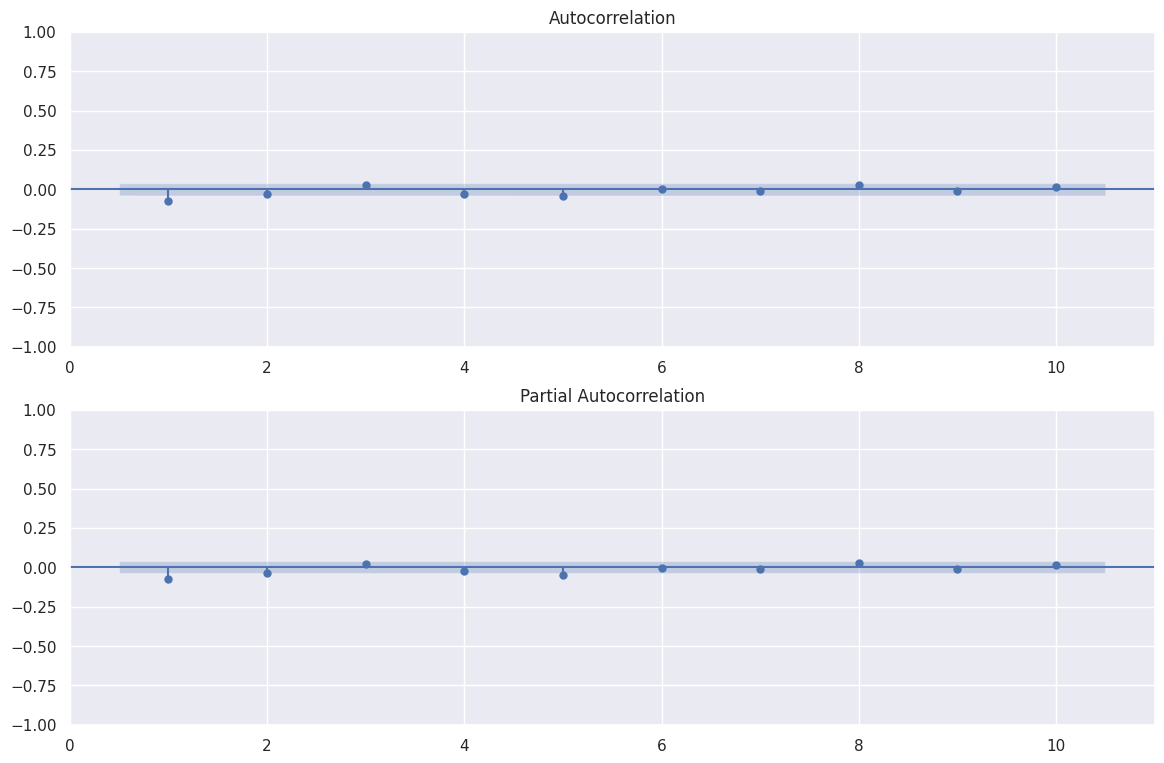

In [21]:
# Autocorrélation et Auto corrélation partielle
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,9))

plot_acf(df_stat, lags=10, zero=False, ax=ax1)
plot_pacf(df_stat, lags=10, zero=False, ax=ax2)
plt.show()

La fonction d'autocorrélation indique le paramètre p et la fonction d'autocorrélation partielle indique le paramètre q. En analysant ces deux fonctions, nous pouvons déduire l'ordre du
modèle. Les barres qui se trouvent à l'intérieur de la zone ombrée en bleu ne sont pas statistiquement significatives.  

Pour les deux paramètres, nous remarquons que les barres statistiquement significatives sont les barres 1 et 5. La barre 5 est dans les deux tracés est pratiquement à l'intérieur de la zone ombrée bleue. Donc, les deux fonctions nous suggèrent un modèle *ARMA (1,1)*.  



Il existe aussi d'autres manières d'identifier le bon ordre du modèle :  [le critère d'information d'Akaike](https://fr.wikipedia.org/wiki/Crit%C3%A8re_d%27information_d%27Akaike) (AIC en anglais) et  [le critère d'information bayésien](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (BIC en Anglais). Plus les valeurs de ces deux critères sont faibles, plus le modèle est bon. L'AIC et le BIC pénalisent les
modèles complexes c'est-à-dire avec un ordre trop élevé. Très souvent les deux critères indiquent le choix du même modèle. Si ce n'est pas le cas, il faudra choisir nous-mêmes. Si l'objectif est d'identifier un bon modèle prédictif, il faut considérer l'AIC. Si l'objectif est d'identifier un bon modèle explicatif, il faut considérer le BIC.

Voyons maintenant comment implémenter tout ceci dans Python :

In [22]:
aic_bic = []
for p in range(6):
  for q in range(6):
    try:
      model = SARIMAX(df, order=(p,1,q))
      resultats = model.fit()
      print(p, q, resultats.aic, resultats.bic)
      aic_bic.append((p, q, resultats.aic, resultats.bic))
    except:
      print(p,q, None, None)

0 0 31986.546772382884 31992.37799259749
0 1 31973.82870169945 31985.49114212866
0 2 31974.28875143764 31991.782412081455
0 3 31975.274969389735 31998.599850248153
0 4 31974.51382602102 32003.66992709404
0 5 31971.936660634834 32006.92398192246
1 0 31974.659337935278 31986.321778364487
1 1 31974.666701467897 31992.16036211171
1 2 31975.194059659825 31998.518940518243
1 3 31976.725557514757 32005.88165858778
1 4 31974.275383169588 32009.262704457215
1 5 31973.774628807012 32014.593170309243
2 0 31973.93434328514 31991.42800392895
2 1 31974.741676886348 31998.066557744765
2 2 31975.239133741845 32004.395234814867
2 3 31973.383370626176 32008.370691913802
2 4 31969.773086853715 32010.591628355945
2 5 31972.966334177385 32019.61609589422
3 0 31974.64593967188 31997.970820530296
3 1 31976.310981849776 32005.467082922798
3 2 31977.16502017813 32012.152341465757
3 3 31968.331114710458 32009.14965621269
3 4 31971.791946011184 32018.44170772802
3 5 31971.60725767113 32024.08823960257
4 0 31975.

Le code ci-dessus nous permet de rechercher le meilleur modèle pour notre série temporelle. Les paramètres p et q varient entre 0 et 5 inclus (valeurs suggérées par les fonctions
d'autocorrélation et d'autocorrélation partielle). Un modèle **ARIMA(p,d,q)** est ajusté directement à notre série temporelle non stationnaire pour chaque combinaison possible de p et
q. Veillez toujours à spécifier l'ordre de différenciation d. Ici d est égal à 1. Pour finir, nous affichons les valeurs de AIC et de BIC pour chaque combinaison de p et q.  

Il peut arriver qu'une combinaison de p et q ne fonctionne pas et résulte donc en une erreur.
Pour pallier cela, nous avons mis les instructions à l'intérieur d'une syntaxe *try...except*.  

C'est très difficile de se retrouver avec tous ces chiffres. Puisque nous avons stocker ce résultat dans une liste, nous allons pouvoir afficher les valeurs dans un ordre bien déterminé ce qui nous permettra de vite connaître la meilleure combinaison de p et q. Notre objectif est d'identifier un bon modèle prédictif donc nous choisirons la combinaison p et q qui donne le plus petit **AIC**.

In [23]:
# Construction d'une dataframe à partir de la liste aic_bic
order_df = pd.DataFrame(aic_bic, columns=['p', 'q', 'AIC', 'BIC'])


# Affichage de order_df dans l'ordre croissant des AIC
order_df.sort_values('AIC').head()

,p,q,AIC,BIC
21,3,3,31968.331115,32009.149656
16,2,4,31969.773087,32010.591628
23,3,5,31971.607258,32024.088240
22,3,4,31971.791946,32018.441708
27,4,3,31971.912843,32018.562604


D'après ce résultat, le meilleur modèle est celui d'ordre (3,3).  

A présent, nous allons construit un modèle **ARIMA(3,1,3)** de prévision des futurs prix des cours du Dow Jones. Mais avant cela, divisons la série en données d'entraînement et  d'évaluation du modèle.

In [24]:
# Création d'un modèle ARIMA(3,1,3)
dow_jones_model = SARIMAX(df, order=(3,1,3))


# Entraînement du modèle
dow_jones_results = dow_jones_model.fit()

### EVALUATION DU MODELE  

Après la construction du modèle, nous devons évaluer sa qualité. Nous analyserons les résidus c'est-à-dire les différences entre les valeurs prédictes par le modèle et les valeurs réelles.

In [25]:
# Résidus
residus = dow_jones_results.resid
print(residus)

Date
2007-12-03    13314.570313
2007-12-04      -51.492926
2007-12-05      200.304810
2007-12-06      182.321008
2007-12-07       29.114187
                  ...     
2017-11-27       13.675410
2017-11-28      264.660519
2017-11-29      130.394326
2017-11-30      336.677511
2017-12-01      -20.060945
Length: 2519, dtype: float64


Pour un modèle idéal, les résidus doivent être normalement distribués. Nous allons vérifier cela à l'aide de 04 graphiques.  

Calculons d'abord l'erreur absolue moyenne, c'est-à-dire la moyenne des valeurs absolues des résidus :

In [26]:
# Erreur absolue moyenne
mae = np.mean(np.abs(residus))
print("L'erreur absolue moyenne est égale à :", mae)

L'erreur absolue moyenne est égale à : 102.52784149706797


Plus l'erreur absolue moyenne est faible, plus le modèle est performant.

Il y a 04 graphiques très souvent utilisés dans l'évaluation d'un modèle de régression d'une série temporelle :  

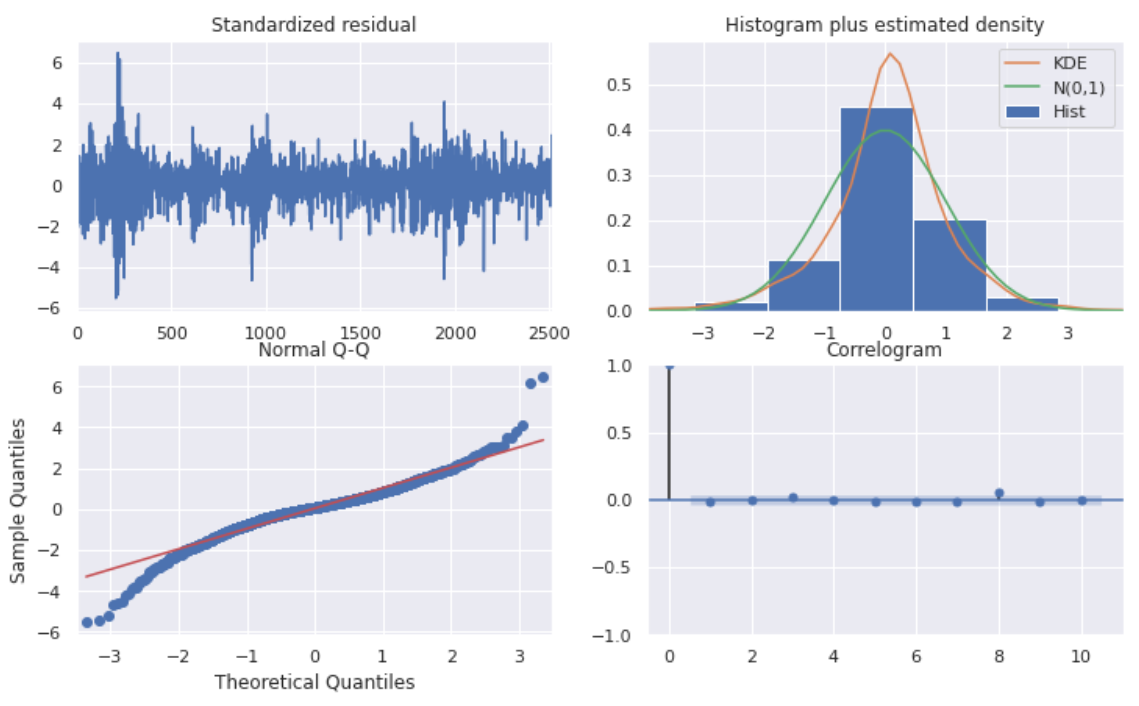

Le graphique donnant les résidus standardisés montre qu'il n'y a pas de structure évidente dans ces résidus ce qui est un bon signe que notre modèle fonctionne correctement.  

L'histogramme donne la distribution des résidus. La courbe verte est une loi normale et la courbe rouge est une version lissée de l'histogramme des résidus du modèle. Pour un modèle idéal, ces deux courbes sont parfaitement superposées donc identiques ce qui n'est pas tellement le cas ici. Dans la réalité il n'y a pas de modèle totalement parfait.  

Le graphique Normal Q-Q montre aussi comment la distribution des résidus de notre modèle (en bleu) se compare avec la loi normale (en rouge). Nous remarquons que les points se retrouvent le long de la droite rouge sauf les points extrêmes.  

Le dernier graphique est le corrélogramme (tracé de la fonction d'autocorrélation) des résidus. Pour un modèle idéal, 95% des corrélations pour un décalage supérieur à zéro ne doivent pas
être significatives en d'autres termes les barres doivent se retrouver à l'intérieur de la zone ombrée bleue. Dans notre cas, toutes les barres ne sont pas significatives donc les résidus ne
sont pas corrélés.  

A partir de ces 04 graphiques, nous pouvons conclure que notre modèle fonctionne correctement.  

En plus de ces 04 graphiques, nous pouvons nous servir du résumé statistique généré par notre
modèle de prévision :

In [27]:
# Résumé statistique du modèle
print(dow_jones_results.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2519
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -15977.166
Date:                Mon, 20 Jan 2025   AIC                          31968.331
Time:                        10:47:18   BIC                          32009.150
Sample:                             0   HQIC                         31983.145
                               - 2519                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1987      0.106      1.879      0.060      -0.009       0.406
ar.L2         -0.4959      0.069     -7.180      0.000      -0.631      -0.361
ar.L3          0.7511      0.099      7.622      0.0

Considérons les valeurs de Prob(Q) et Prob(JB) dans le tableau ci-dessus :
* Prob(Q) est la p-valeur associée à l'hypothèse nulle selon laquelle les résidus du modèle ne sont pas corrélés ;
* Prob(JB) est la p-valeur associée à l'hypothèse nulle selon laquelle les résidus sont normalement distribués ;  

Dans le cas présent *Prob(Q) = 0.25* donc supérieure à 0.05. Alors on accepte l'hypothèse selon laquelle les résidus de notre modèle ne sont pas corrélés. *Prob(JB) = 0.00* donc inférieure à
0.05. Alors on rejette l'hypothèse nulle selon laquelle les résidus de notre modèle sont normalement distribués. Ceci est sûrement dû aux valeurs extrêmes (Voir graphique Normal QQ).  

Alors les résidus de notre modèle ne sont pas corrélés (ce qui est bien) et sont pratiquement normalement distribués sauf pour les valeurs extrêmes.

### PREVISIONS  

Passons à présent à la prévision des prix de l'indice dans les 365 prochains jours de trading.

In [28]:
# Prévision des futurs 365 prix de l'indice
mean_price_forecast = dow_jones_results.get_forecast(steps = 365).predicted_mean
mean_price_forecast

,predicted_mean
2519,24204.631608
2520,24199.241301
2521,24196.395700
2522,24178.255461
2523,24172.013803
...,...
2879,24154.437774
2880,24154.436556
2881,24154.433467
2882,24154.436444


Nous avons une série des futurs prix de l’indice du Dow Jones. Calculons les intervalles de confiance des prévisions ci-dessus :

In [29]:
# Intervalles de confiance des prévisions
intervals = dow_jones_results.get_forecast(steps = 365).conf_int()
intervals

,lower Adj Close,upper Adj Close
2519,23933.957381,24475.305836
2520,23827.299501,24571.183101
2521,23748.921833,24643.869566
2522,23665.777786,24690.733136
2523,23605.510060,24738.517546
...,...,...
2879,19844.715783,28464.159764
2880,19838.778446,28470.094666
2881,19832.847363,28476.019572
2882,19826.930583,28481.942304


BEAU TRAVAIL Nous avons calculé les futurs 365 prix ajustés de l’indice du Dow Jones avec leurs intervalles de confiance.

## CONCLUSION  
Dans ce projet, vous avez appris comment modéliser une série temporelle. Nous sommes partis de la collecte des données de l'indice du Dow Jones de 2007 à 2017 sur Yahoo Finance jusqu'à
la prévision des prix ajustés de l'année 2018. Le flux de travail utilisé dans ce projet peut être appliqué à tout projet de modélisation d'une série chronologique et ceci dans n'importe quel domaine (Finance, Climat, etc.).  


La modélisation des cours boursiers est un domaine de recherche très actif. Plusieurs organisations financières et Instituts de recherche dans le monde se sont spécialisées dans ce domaine. Vous pouvez aussi contribuer à ces recherches et même gagner de l'argent en passant.
En effet, il existe deux communautés particulièrement intéressantes, [Quantopian](https://www.quantopian.com/) et
 [Numerai](https://numer.ai/), où vous pouvez soumettre vos algorithmes de prévision des prix des actions dans des compétitions. Si votre algorithme surpasse les algorithmes des autres concurrents, vous gagnerez un prix en espèces, et si vous obtenez la licence pour votre algorithme, vous tirerez
un profit des transactions qui seront effectuées via votre algorithme sous licence. Ces deux plateformes disposent également de plusieurs tutoriels vous permettant d'apprendre.